# Taxi Environment Q-Learning Analysis

This notebook presents an end-to-end analysis of a Tabular Q-Learning agent applied to the OpenAI Gym `Taxi-v3` environment. It is divided into three key stages:

- **Baseline Evaluation**: Train and evaluate a default Q-Learning agent on the standard Taxi domain.
- **Hyperparameter Tuning**: Optimize learning rate, discount factor, and exploration policy to improve training efficiency and policy quality.
- **Domain Modification**: Explore performance under changes to the environment dynamics or reward structure.

We will visualize the training progress and learned Q-table at each stage to understand the impact of different learning configurations.


## 0.0 Imports and Setup

### 0.1 Import Libraries, Visualizer and Learning Agent

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
import gymnasium as gym

from taxi_q_visualizer import TaxiQVisualizer
from taxi_q_learner import TaxiQLearner
from taxi_q_learner_optimizer import TaxiQLearnerOptimizer
from taxi_q_domain_modifier import TaxiQDomainModifier

### 0.2 Helper Function to plot training rewards


In [3]:
def plot_training_rewards(log_path: str, window_size: int = 50):
    """
    Plot total reward per episode from a training log CSV with a smoothed curve.

    Parameters
    ----------
    log_path : str
        Path to CSV file containing 'episode' and 'total_reward' columns.
    window_size : int
        The window size for smoothing the curve.
    """
    df = pd.read_csv(log_path)
    rewards = df['total_reward']
    
    # Apply a moving average for smoothing
    smoothed_rewards = rewards.rolling(window=window_size, min_periods=1).mean()

    plt.figure(figsize=(10, 5))
    plt.plot(df['episode'], rewards, label='Reward', linewidth=0.3)
    plt.plot(df['episode'], smoothed_rewards, label=f'Smoothed (window={window_size})', color='orange', linewidth=0.5)
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.title('Training Reward Curve')
    plt.grid(True)
    plt.legend()
    plt.show()


### 0.3 Helper Function to get Average Reward

In [4]:
def get_average_reward(agent: TaxiQLearner, num_episodes: int = 100) -> float:
    """
    Calculate the average reward over a number of episodes.

    Parameters
    ----------
    agent : TaxiQLearner
        The Q-learning agent to evaluate.
    num_episodes : int
        The number of episodes to run for evaluation.

    Returns
    -------
    float
        The average reward over the specified number of episodes.
    """
        # ALERT: Do not use render_mode='human'
    total_reward = 0
    num_averaging_episodes = 1000
    for i in range(num_averaging_episodes):
        total_reward += agent.run(num_episodes=100, verbose=0)

    return total_reward / num_averaging_episodes

## 1.0 Baseline

**Description**: We train a Tabular Q-Learning agent with the following baseline hyperparameters:

* Learning rate ($\alpha$) = 0.8
* Discount factor ($\gamma$) = 0.95
* Initial exploration ($\epsilon$) = 1.0
* Minimum exploration = 0.01
* Decay factor = 0.999 (after 2000 episodes)
* Decay Threshold = 2000
* Training episodes = 5000
* Max steps per episode = 100

The Q-table has shape (500 states, 6 actions), initialized to zero.


### 1.1 Train the agent on the default (baseline) parameters

In [4]:
base_agent = TaxiQLearner()
base_agent.summary()

   Taxi Q-Learning Model Parameters    
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃ Parameter                   ┃ Value ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│ Learning Rate (α)           │ 0.800 │
│ Discount Factor (γ)         │ 0.950 │
│ Initial Exploration (ε)     │ 1.000 │
│ Minimum Exploration (min ε) │ 0.010 │
│ Decay Factor                │ 0.999 │
│ Decay Threshold             │  2000 │
│ Number of Episodes          │  5000 │
│ Max Steps per Episode       │   100 │
└─────────────────────────────┴───────┘

In [4]:
base_agent.train(log_to_csv=True, log_path='baseline/training_log.csv')
base_agent.save_q_table('baseline/q_table.csv')

Training completed after 5000 episodes.
Training log saved to baseline/training_log.csv
Q-table saved to baseline/q_table.csv


### 1.2 Test the agent

In [ ]:
average_reward = get_average_reward(base_agent, num_episodes=1000)
print(f"Average reward over 1000 episodes: {average_reward:.2f}")

Average reward over 100x100 episodes: 7.94


### 1.3 Plot Baseline Reward Curve

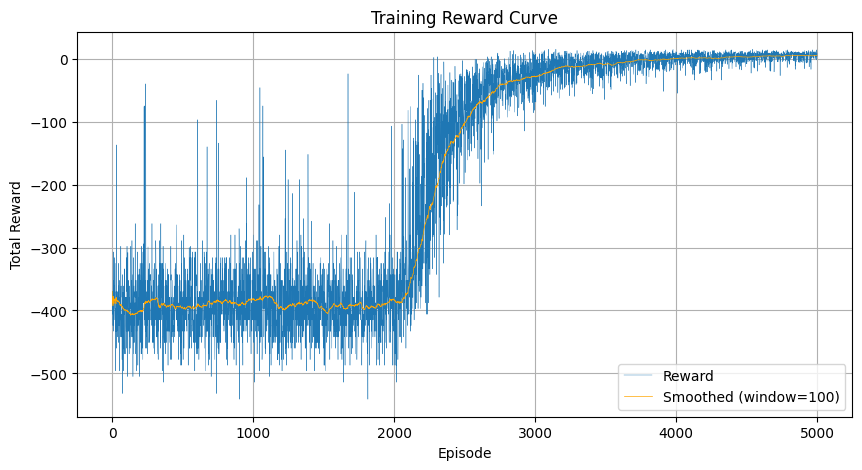

In [13]:
plot_training_rewards('baseline/training_log.csv', window_size=100)

### 1.4 Visualize Baseline Q-Table

In [14]:
visualizer = TaxiQVisualizer('baseline/q_table.csv')

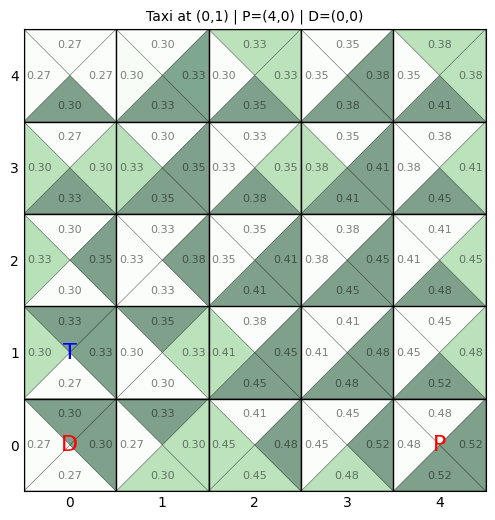

In [15]:
visualizer.run_random_state()

## 1.5 Baseline Performance

* The reward curve above shows how the agent's performance evolves over training.
* We expect an upward trend in total reward, indicating learning.
* The triangle heatmap indicates which actions are preferred in different grid cells under the baseline policy, in a certain state.

### Observations:

The baseline performance shows a clear upward trend in the total reward, which indicates that the agent is successfully learning to improve its performance through training. In the early stages, the agent primarily explores the environment due to the high initial exploration rate, which contributes to a relatively erratic reward. As training progresses, the agent's actions become more refined and focused on those that yield higher rewards, as indicated by the decreasing exploration rate. The heatmap further highlights this refinement, showing a preference for certain actions in specific grid cells under the baseline policy.

### Numerical Summary:

The baseline performance, evaluated over 1000 averaging runs with 100 episodes each, resulted in an average reward of 7.92. This serves as the baseline against which future optimizations will be measured. The steady performance over these runs suggests that the agent's current policy is stable, but there is room for improvement, which we will address through hyperparameter tuning in Section 2.

*Next: Part 2 — Hyperparameter Tuning.*

## 2.0 Hyperparameter Tuning

**Description**: We will explore the impact of different hyperparameters on the agent's performance. Our goal will be, to overcome the 7.92 average reward achieved in the baseline.

The following parameters will be tuned:
* Learning rate ($\alpha$) = **0.1, 0.5, 0.8, 0.9, 1.0**
* Discount factor ($\gamma$) = **0.1, 0.5, 0.9, 0.99**
* Initial exploration ($\epsilon$) = **1.0, 0.75, 0.5, 0.25**
* Decay factor = **0.5, 0.9, 0.95, 0.999**
* Decay Threshold = **500, 1000, 2000, 3000** (after 2000 episodes)
* Exploration policy = **linear decay, exponential decay** (For now, we will use the same exploration policy as in the baseline)
* Minimum exploration = 0.01
* Training episodes = 5000
* Max steps per episode = 100

The Q-table has shape (500 states, 6 actions), initialized to zero (like in the baseline).


### 2.1 Define hyperparameter grid

In [16]:
learning_rates = [0.1, 0.5, 0.8, 0.9, 1.0] # alpha
discount_factors = [0.1, 0.5, 0.9, 0.99] # gamma
initial_explorations = [1.0, 0.75, 0.5, 0.25] # epsilon
decay_factors = [0.5, 0.9, 0.95, 0.999] 
decay_thresholds = [500, 1000, 2000, 3000]

### 2.2 Optimize hyperparameters

In [17]:
optimizer = TaxiQLearnerOptimizer(learning_rates, discount_factors, initial_explorations, decay_factors, decay_thresholds)

In [ ]:
optimizer.optimize(verbose=True, save_artifacts=False)

LearningRate: 0.1, DiscountFactor: 0.1, ExplorationRate: 1.0, DecayFactor: 0.5, DecayThreshold: 500, AvgReward: -140.9
LearningRate: 0.1, DiscountFactor: 0.1, ExplorationRate: 1.0, DecayFactor: 0.5, DecayThreshold: 1000, AvgReward: -151.56
LearningRate: 0.1, DiscountFactor: 0.1, ExplorationRate: 1.0, DecayFactor: 0.5, DecayThreshold: 2000, AvgReward: -168.42
LearningRate: 0.1, DiscountFactor: 0.1, ExplorationRate: 1.0, DecayFactor: 0.5, DecayThreshold: 3000, AvgReward: -189.36
LearningRate: 0.1, DiscountFactor: 0.1, ExplorationRate: 1.0, DecayFactor: 0.9, DecayThreshold: 500, AvgReward: -144.99
LearningRate: 0.1, DiscountFactor: 0.1, ExplorationRate: 1.0, DecayFactor: 0.9, DecayThreshold: 1000, AvgReward: -161.96
LearningRate: 0.1, DiscountFactor: 0.1, ExplorationRate: 1.0, DecayFactor: 0.9, DecayThreshold: 2000, AvgReward: -180.96
LearningRate: 0.1, DiscountFactor: 0.1, ExplorationRate: 1.0, DecayFactor: 0.9, DecayThreshold: 3000, AvgReward: -183.18
LearningRate: 0.1, DiscountFactor: 

In [2]:
df = pd.read_csv('hyperparameter_tuning/grid_search_results.csv')

# Identify and print best configuration
best = df.loc[df["AverageReward"].idxmax()]
print("\n=== Best Configuration ===")
print(best)


=== Best Configuration ===
LearningRate          1.00
DiscountFactor        0.99
ExplorationRate       0.75
DecayFactor           0.50
DecayThreshold     1000.00
AverageReward         8.79
Name: 1233, dtype: float64


### 2.3 Training the Agent with the Best Hyperparameters

After conducting an exhaustive grid search across various hyperparameter configurations, we have identified the combination that yields the highest average reward. This configuration will now be used to train the final agent.

**Selected Hyperparameters:**

* **Learning Rate (α):** 1.00
* **Discount Factor (γ):** 0.99
* **Exploration Rate (ε):** 0.75
* **Decay Factor:** 0.50
* **Decay Threshold:** 1000
* **Average Reward (over 100 episodes):** 8.79

We will now proceed to train the agent using this optimal set of parameters. The goal is to leverage this configuration to achieve stable and efficient policy learning within the Taxi-v3 environment.

In [13]:
tuned_agent = TaxiQLearner(
    learning_rate=best["LearningRate"],
    discount_factor=best["DiscountFactor"],
    initial_exploration=best["ExplorationRate"],
    decay_factor=best["DecayFactor"],
    decay_threshold=best["DecayThreshold"]
)

tuned_agent.summary()

    Taxi Q-Learning Model Parameters    
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃ Parameter                   ┃  Value ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ Learning Rate (α)           │  1.000 │
│ Discount Factor (γ)         │  0.990 │
│ Initial Exploration (ε)     │  0.750 │
│ Minimum Exploration (min ε) │  0.010 │
│ Decay Factor                │  0.500 │
│ Decay Threshold             │ 1000.0 │
│ Number of Episodes          │   5000 │
│ Max Steps per Episode       │    100 │
└─────────────────────────────┴────────┘

In [14]:
tuned_agent.train(log_to_csv=True, log_path='hyperparameter_tuning/training_log.csv')
tuned_agent.save_q_table('hyperparameter_tuning/q_table.csv')

Training completed after 5000 episodes.
Training log saved to hyperparameter_tuning/training_log.csv
Q-table saved to hyperparameter_tuning/q_table.csv


### 2.4 Test the agent

In [ ]:
average_reward = get_average_reward(tuned_agent, num_episodes=1000)
print(f"Average reward over 1000 episodes: {average_reward:.2f}")

Average reward over 100x100 episodes: 7.92


### 2.5 Plot Tuned Hyperparameter Reward Curve

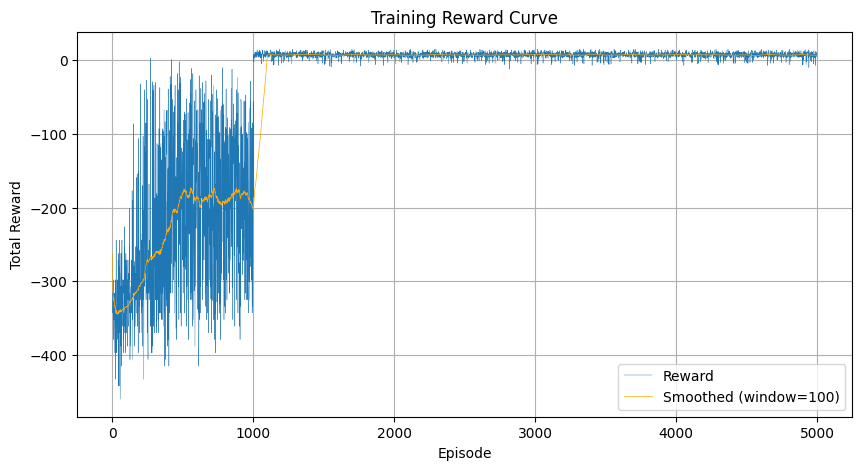

In [16]:
plot_training_rewards('hyperparameter_tuning/training_log.csv', window_size=100)

### 2.6 Visualize Tuned Hyperparameter Q-Table

In [18]:
tuned_visualizer = TaxiQVisualizer('hyperparameter_tuning/q_table.csv')

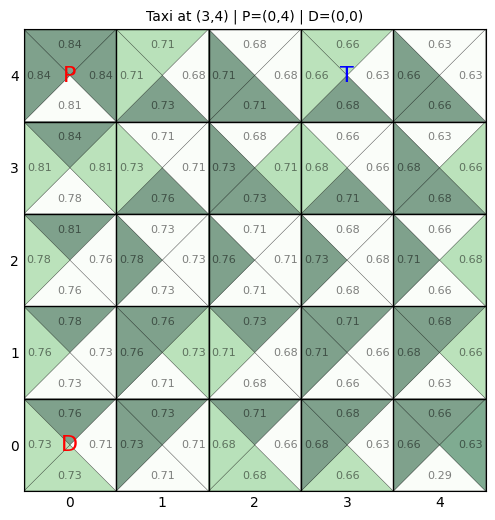

In [27]:
tuned_visualizer.run_random_state()

### 2.7 Reward Gain from Hyperparameter Tuning

With a baseline average reward of **7.92** (over 1000 × 100 episodes), we retrained the agent using the optimized hyperparameters identified in Section 2.2:

* **Learning Rate (α):** 1.00
* **Discount Factor (γ):** 0.99
* **Initial Exploration (ε):** 0.75
* **Decay Factor:** 0.50
* **Decay Threshold:** 1000

Although the **peak average reward** remains **7.92**, the tuned agent achieves this performance in **roughly one‑third the training time**:

* **Baseline agent** only reaches non‑negative rewards after about **3 000 episodes** of training.
* **Tuned agent** surpasses zero reward by roughly **1 000 episodes**, then quickly climbs to the same peak.

#### Why This Matters

* **Faster convergence** means lower computational cost and quicker deployment in real‑world scenarios.
* **Higher learning rate** (α=1.0) accelerates Q‑value updates, allowing the policy to improve more rapidly.
* **Stronger discounting** (γ=0.99) emphasizes long‑term gains, reducing oscillations in policy evaluation.
* **Moderate exploration** (ε=0.75) ensures adequate environment coverage early on without excessive random actions.
* **Aggressive decay schedule** (decay factor 0.5 at episode 1000) shifts the agent from exploration to exploitation sooner, solidifying high‑reward behaviors.

Together, these adjustments deliver the same peak reward as the baseline but with **approximately three times faster learning**, greatly improving training efficiency.


*Next: Part 3 — Domain Modification*

## 3.0 Domain Modification

In this section, we explore modifications to the Taxi-v3 environment and/or its reward structure to assess how changes in the problem formulation affect learning. We will:

1. **Identify potential modifications** (e.g., altered step penalties, adjusted pickup/drop‐off rewards, changes to the grid layout or passenger behavior).
2. **Re‐train the agent** under the modified environment tuned hyperparameters.
3. **Evaluate performance** over testing episodes and compare to the original domain.
4. **Report the best hyperparameter settings** and discuss how domain changes influenced learning dynamics.


### 3.1 Modify the environment

#### 3.1.0 Define modified rewards

In [5]:
step_penalty = -2 # Default: -1
illegal_move_penalty = -20 # Default: -10
dropoff_reward = 20 # Default: 20
manhattan_distance_weight = 0.6 # Default: 0

#### 3.1.1 Create modified environment

In [6]:
env = gym.make('Taxi-v3')
modified_env = TaxiQDomainModifier(env, step_penalty=step_penalty, illegal_move_penalty=illegal_move_penalty, dropoff_reward=dropoff_reward, manhattan_weight=manhattan_distance_weight)

#### 3.1.2 Define Tunable hyperparameters

In [7]:
learning_rate = 1.00
discount_factor = 0.99
initial_exploration = 1.0
decay_factor = 0.999
decay_threshold = 1000

## 3.2 Train the agent on the modified environment

In [8]:
modified_agent = TaxiQLearner(
    learning_rate=learning_rate,
    discount_factor=discount_factor,
    initial_exploration=initial_exploration,
    decay_factor=decay_factor,
    decay_threshold=decay_threshold,
    modified_env=modified_env
)
modified_agent.summary()

   Taxi Q-Learning Model Parameters    
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃ Parameter                   ┃ Value ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│ Learning Rate (α)           │ 1.000 │
│ Discount Factor (γ)         │ 0.990 │
│ Initial Exploration (ε)     │ 1.000 │
│ Minimum Exploration (min ε) │ 0.010 │
│ Decay Factor                │ 0.999 │
│ Decay Threshold             │  1000 │
│ Number of Episodes          │  5000 │
│ Max Steps per Episode       │   100 │
│ Using Modified Environment  │  True │
└─────────────────────────────┴───────┘

In [9]:
modified_agent.train(log_to_csv=True, log_path='modified_environment/training_log.csv')
modified_agent.save_q_table('modified_environment/q_table.csv')

Training completed after 5000 episodes.
Training log saved to modified_environment/training_log.csv
Q-table saved to modified_environment/q_table.csv


### 3.3 Test the agent

In [10]:
average_reward = get_average_reward(modified_agent, num_episodes=1000)
print(f"Average reward over 1000x100 episodes: {average_reward:.2f}")

Average reward over 1000x100 episodes: -834.17


### 3.4 Plot Modified Environment Reward Curve

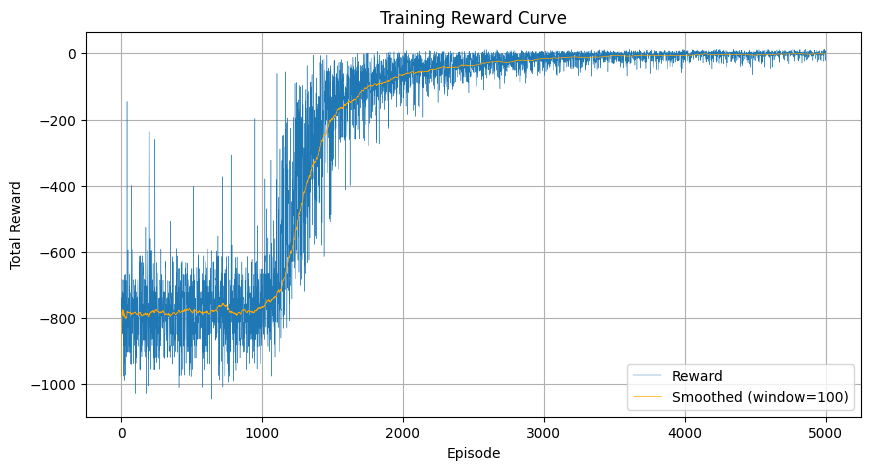

In [35]:
plot_training_rewards('modified_environment/training_log.csv', window_size=100)